In the previous training of Resnet 50, most of the errors were "neighbor errors" in which the predicted class was next to the true class. There were only 5 classes, which meant that each class included a broad range of focus levels. To attempt to improve on this, I re-wrote the image sorter to include 7 classes.

0) Very out negative
1) Medium out negative
2) Slightly out negative
3) Acceptable
4) Slightly out positive
5) Medium out positive
6) Very out positive

This notebook documents training the Resnet50 network on these 7 classes.

In [10]:
# Quick check to see how many images there are per class

def count_images(file_path):
    # Finds class folders, makes a list of classes, and counts how many images are in each class
    import os
    from pathlib import Path
    
    image_counter = []
    
    for class_name in os.listdir(file_path):
        # Exclude .DS_Store
        if class_name != '.DS_Store':

            # Make a Path to the class directory
            class_dir = Path(file_path) / class_name

            # Note that this is set to work with .png images and needs modification
            # to work with other types
            image_counter.append(len(os.listdir(class_dir)))
                          
    return image_counter


In [11]:
train_path = '/Users/zplab/Desktop/VeraPythonScripts/vera_autofocus/microscope_images/train'
train_counts = count_images(train_path)
train_counts

[165, 196, 114, 95, 38, 133, 114]

In [12]:
test_path = '/Users/zplab/Desktop/VeraPythonScripts/vera_autofocus/microscope_images/test'
test_counts = count_images(test_path)
test_counts

[152, 228, 120, 100, 40, 140, 120]

In [14]:
# Import the image processing functions and class
from image_import import process_image, de_process_image, wormDataset

# Import all needed libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
# These last two are used to save info about how the training progressed
import pickle
import datetime

# Set the full path to the main image directory
train_dir = '/Users/zplab/Desktop/VeraPythonScripts/vera_autofocus/microscope_images/train'
test_dir = '/Users/zplab/Desktop/VeraPythonScripts/vera_autofocus/microscope_images/test'
num_train = 10
num_test = 10

means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

traindata = wormDataset(train_dir, means, stds)
testdata = wormDataset(test_dir, means, stds)

# Load from the training and test sets
trainloader = torch.utils.data.DataLoader(traindata, batch_size=num_train, shuffle=True)
testloader = torch.utils.data.DataLoader(testdata, batch_size=num_test, shuffle=True)

# Get the classes
class_names = traindata.classes
print('Detected ' + str(len(class_names)) + ' classes in training data')
print(class_names)

# Print out how many images are in the trainloader and testloader
print("Train batch size = " + str(num_train) + ', test batch size = ' + str(num_test))
print('Trainloder length = ' + str(len(trainloader)) + ', testloader length = ' + str(len(testloader)))

Detected 7 classes in training data
['0', '6', '1', '4', '3', '2', '5']
Train batch size = 10, test batch size = 10
Trainloder length = 86, testloader length = 90


In [17]:
%%capture 
# Prevent printing out the model architecture
# Check if cuda is available, and set pytorch to run on GPU or CPU as appropriate
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Cuda available, running on GPU')
else:
    device = torch.device("cpu")
    print('Cuda is not available, running on CPU')
    # Give the user a message so they know what is going on

model = models.resnet50(pretrained=True)
#print(model) 
# Printing the model shows some of the internal layers, not expected to
# understand these but neat to see

# Freeze the pre-trained layers, no need to update featue detection
for param in model.parameters():
    param.requires_grad = False

# Get the number of features the model expects in the final fully connected layer, this is different
# in different models
num_ftrs = model.fc.in_features

# Re-define the final fully connected layer (model.fc, fc = fully connected)
model.fc = nn.Sequential(nn.Linear(num_ftrs, 512), # 2048 inputs to 512 outputs 
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 # The next line needs to be modified for the number of classes
                                 # in the data set. For the microscope images I currently have 
                                 # five classes, so there are 5 outputs
                                 nn.Linear(512, 7), # 512 inputs to 7 outputs
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

In [18]:
# Train the network
epochs = 2
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses, accuracy_tracker = [], [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader)) 
            accuracy_tracker.append(accuracy/len(testloader))                     
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'resnet50_7cat.pth')

Epoch 1/2.. Train loss: 3.344.. Test loss: 1.940.. Test accuracy: 0.313
Epoch 1/2.. Train loss: 1.689.. Test loss: 1.599.. Test accuracy: 0.466
Epoch 1/2.. Train loss: 1.182.. Test loss: 1.440.. Test accuracy: 0.472
Epoch 1/2.. Train loss: 0.977.. Test loss: 0.902.. Test accuracy: 0.681
Epoch 1/2.. Train loss: 1.102.. Test loss: 1.004.. Test accuracy: 0.556
Epoch 1/2.. Train loss: 0.935.. Test loss: 0.899.. Test accuracy: 0.666
Epoch 1/2.. Train loss: 0.878.. Test loss: 0.741.. Test accuracy: 0.678
Epoch 1/2.. Train loss: 1.007.. Test loss: 0.761.. Test accuracy: 0.722
Epoch 2/2.. Train loss: 0.944.. Test loss: 0.603.. Test accuracy: 0.810
Epoch 2/2.. Train loss: 0.781.. Test loss: 0.585.. Test accuracy: 0.790
Epoch 2/2.. Train loss: 0.643.. Test loss: 0.637.. Test accuracy: 0.758
Epoch 2/2.. Train loss: 1.044.. Test loss: 0.741.. Test accuracy: 0.704
Epoch 2/2.. Train loss: 0.881.. Test loss: 0.829.. Test accuracy: 0.682
Epoch 2/2.. Train loss: 1.025.. Test loss: 0.607.. Test accuracy

In [42]:
# Save the information about how training went
# Get a unique date and time to id this training round
now = datetime.datetime.now()
time_string = (':').join([str(now.hour), str(now.minute)]) 
date_string = ('-').join([str(now.month), str(now.day), str(now.year)])
file_name = ('_').join(['resnet18_training', date_string, time_string])

fileObject = open(file_name, 'wb')
training_data = [train_losses, test_losses, accuracy_tracker]
pickle.dump(training_data, fileObject)
fileObject.close
fileObject.close()

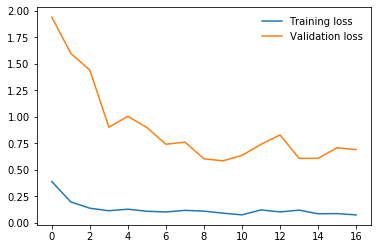

In [43]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [19]:
# Evaluate on all images in the test loader
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on ' + str(total) + ' test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on 900 test images: 67 %


The network definitely improved with training and the results are substantially better than chance. However, the training loss and accuracy have plateaud, and the final accuracy is only 67% which is not as good at the 5 category model.

In [77]:
# Evaluate on all images in the test loader
correct = 0
neighbor = 0 # Error in which the predicted class is next to the correct class, ex. slightly out pos vs. very out pos
opposite = 0 # Error in which the predicted is the opposite sign of the correct class, neg vs. pos
miss_accept = 0 # Error in which an acceptable image is classed out of focus, and vice versa
total = 0

confusion_matrix = np.zeros((7, 7))

class_names = testdata.classes

with torch.no_grad():
    for data in testloader:
        # This is processing in batches, the number of things in images and labels is the
        # the same as the batch size
        images, labels = data
        outputs = model(images)
        predicted = torch.max(outputs.data, 1)
        num_labels = labels.size(0)
        total += num_labels
        for i in range(num_labels): # Iterate through the labels in the batch
            
            # Increase the cell corresponding to the label / prediction pair by one
            confusion_matrix[labels[i], predicted.indices[i]] += 1
            
print(confusion_matrix)

[[147.   0.   0.   0.   0.   5.   0.]
 [  4. 186.   0.   3.   0.   2.  33.]
 [ 66.   0.   2.   1.   0.  51.   0.]
 [  0.   0.   0.  74.   1.  13.  12.]
 [  0.   0.   0.  23.   0.  17.   0.]
 [  4.   0.   1.  18.   0. 117.   0.]
 [  0.  18.   0.  48.   0.   2.  52.]]


In [26]:
# Validation check by adding up the rows and seeing if this matches the true image counts from the folder
print('Images in folders:')
print(test_counts)
print('')

print('Labels in Confusion Matrix:')
print(np.sum(confusion_matrix, axis=1))

Images in folders:
[152, 228, 120, 100, 40, 140, 120]

Labels in Confusion Matrix:
[152. 228. 120. 100.  40. 140. 120.]


Summing across rows (each row corresponds to a label) returns exactly the same number of labels as there are images corresponding to that label in the image folders. This indicates that the confusion matrix is an accurate count of images and their classification.

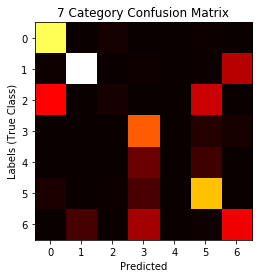

In [41]:
# Make a nicer version of the confusion matrix with axis labels
plt.title('7 Category Confusion Matrix')
plt.ylabel('Labels (True Class)')
plt.xlabel('Predicted')
plt.imshow(confusion_matrix, cmap='hot', interpolation='nearest')
plt.show()

Using the confusion matrix, we can think about what kind of errors are occuring. Below, the percent accurate is different from that obtained using an alternate method. I think this is due to rounding, the values are 67% vs. 66%

In [34]:
# Percent accurate
percent_accurate = np.sum(np.diagonal(confusion_matrix)) / np.sum(confusion_matrix) * 100
print(percent_accurate)

66.0


In [38]:
# Row 3 is true acceptable, column 3 is predicted acceptable
# Errors in which an acceptable image is mistaken for out of focus
(np.sum(confusion_matrix[3,:]) - confusion_matrix[3,3]) / np.sum(confusion_matrix) * 100

1.2222222222222223

In [39]:
# Errors in which an out of focus image is mistaken for acceptable
(np.sum(confusion_matrix[:,3]) - confusion_matrix[3,3]) / np.sum(confusion_matrix) * 100

9.555555555555555

The model is almost 10 times more likely to call an out of focus image acceptable than to miss a true acceptable image. This is an important distinction to keep in mind for developing a search algorithm, it might be a good idea to double check "acceptable" images. The model decciding that out of focus is acceptable will result in failure to focus the microscope, as opposed to other types of error which might make it take longer to reach the correct focus but can be overcome.

In [52]:
# Percent of failure errors
percent_failure = (np.sum(confusion_matrix[3,:]) + np.sum(confusion_matrix[:,3]) - (2 * confusion_matrix[3,3])) / np.sum(confusion_matrix) * 100
print(percent_failure)

10.777777777777779


In [57]:
# Errors in which the predicted class is a neighbor of the true class
# Subset the confusion matrix and take the diagonals to get the cells on either side of the main diagonal
# (one class off vs. accurate predictions)
neighbors_pos = np.diagonal(confusion_matrix[1:, :6])
np.sum(neighbors_pos) / np.sum(confusion_matrix) * 100

3.3333333333333335

In [58]:
neighbors_neg = np.diagonal(confusion_matrix[:6, 1:])
np.sum(neighbors_neg) / np.sum(confusion_matrix) * 100

1.5555555555555556

In [60]:
percent_neighbor = (np.sum(neighbors_pos) + np.sum(neighbors_neg)) / np.sum(confusion_matrix) * 100 
print(percent_neighbor)

4.888888888888889


The model is twice as likely to make neighbor errors in the positive direction compared to the negative direction. The rate of neighbor errors is still low, though.

In [69]:
# Errors in which the model gets the direction wrong
# Thinks the plane of focus is above best focus when it is below, and vice-versa
# These are on the upper right to lower left diagonal, get this by flipping the array
np.diagonal(np.fliplr(confusion_matrix))


array([ 0.,  1.,  0., 89.,  0.,  0.,  0.])

Column 3 is acceptable / acceptable, there is only one opposite error out of all these samples.

In [73]:
percent_opposite = (np.sum(np.diagonal(np.fliplr(confusion_matrix))) - confusion_matrix[3,3]) / np.sum(confusion_matrix) * 100
print(percent_opposite)

0.1111111111111111


In [88]:
percent_other = 100 - percent_failure - percent_neighbor - percent_opposite - percent_accurate
print(percent_other)

18.22222222222223


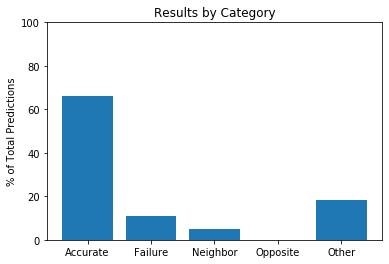

In [89]:
bars = ['Accurate', 'Failure', 'Neighbor', 'Opposite', 'Other']
y_pos = np.arange(len(bars))
matplotlib.pyplot.bar(y_pos, [percent_accurate, percent_failure, percent_neighbor, percent_opposite, percent_other])
plt.title('Results by Category')
plt.ylabel('% of Total Predictions')
plt.xticks(y_pos, bars)
plt.ylim(0, 100)
plt.show()

With more classes to categorize into, the number of 'other' errors goes up. This is because there are more non neighbor and opposite ways to go wrong. The most important kind of error to minimize is missing / wrongly identifying acceptable focus. As noted above, only 1% of these errors involve missing acceptable focus while around 9% involve wrongly predicting acceptable for an out of focus image.

As with other models, there are almost no opposite errors.